In [153]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from plotnine import *
import plotnine
flag_dict = dict(zip(sorted(list(set(flag_df['flag']))), ['primary','unmapped','primary','secondary','secondary']))

In [154]:
# read in flag table
flag_df = pd.read_csv('/GB100_1/86_1B/outs/binned_bams/output_samflag.txt', delimiter=' ', header=None)
flag_df.columns = ['barcode','flag','count']
flag_df['type'] = flag_df['flag'].map(flag_dict)
flag_counts  = flag_df.drop('flag',axis=1).groupby(['barcode','type']).sum()
flag_counts = flag_counts.unstack().reset_index()
flag_counts = flag_counts.fillna(0)
flag_counts[('count','total_reads')] = flag_counts[('count','primary')] +\
                                 flag_counts[('count','secondary')] +\
                                 flag_counts[('count','unmapped')]
flag_counts['pct_unmapped'] = flag_counts[('count','unmapped')] / flag_counts[('count','total_reads')]
flag_counts['pct_secondary'] = flag_counts[('count','secondary')] / flag_counts[('count','total_reads')]
flag_counts = flag_counts.sort_values(('count','total_reads'), ascending=False)

# read in filtered bc table & merge
bc_df = pd.read_csv('/GB100_1/86_1B/outs/filtered_gene_bc_matrices/mm10-1.2.0/barcodes.tsv', header=None)
bc_df.columns = ['barcode']
bc_df['barcode'] = [x.split("-")[0] for x in bc_df['barcode']]
filtered_flagCounts = pd.merge(bc_df, flag_counts, 'inner', 'barcode')
filtered_flagCounts = filtered_flagCounts.iloc[:,[0,4,5,6]]
filtered_flagCounts.columns = ['barcode', 'total_reads','pct_unmapped','pct_secondary']

# read in MT data & merge
mt_df = pd.read_csv('/GB100_1/86_1B/outs/binned_bams/MT_samflag.txt', delimiter=' ', header=None)
mt_df.columns = ['barcode','flag','count']
mt_df = mt_df.drop('flag',axis=1).groupby('barcode').sum().reset_index()
mt_df.columns = ['barcode','MT_count']
filtered_flagCounts = pd.merge(filtered_flagCounts, mt_df, 'inner', 'barcode')
filtered_flagCounts['pct_MT'] = filtered_flagCounts['MT_count'] / filtered_flagCounts['total_reads']
filtered_flagCounts= filtered_flagCounts.drop('MT_count',axis=1)

# save
# filtered_flagCounts.to_csv('')

               total  pct_unmapped  pct_secondary       pct_MT
count    1144.000000   1144.000000    1144.000000  1144.000000
mean   122575.199301      0.167978       0.401779     0.003971
std     92227.055491      0.031077       0.079584     0.002421
min      8469.000000      0.118396       0.204121     0.000072
25%     58695.750000      0.148448       0.344925     0.002427
50%     90505.500000      0.163788       0.400632     0.003424
75%    155755.750000      0.181170       0.458471     0.004859
max    573669.000000      0.564766       0.689018     0.027137
                  total  pct_unmapped  pct_secondary    pct_MT
total          1.000000     -0.266140       0.205667 -0.391559
pct_unmapped  -0.266140      1.000000      -0.016158  0.102024
pct_secondary  0.205667     -0.016158       1.000000 -0.255743
pct_MT        -0.391559      0.102024      -0.255743  1.000000


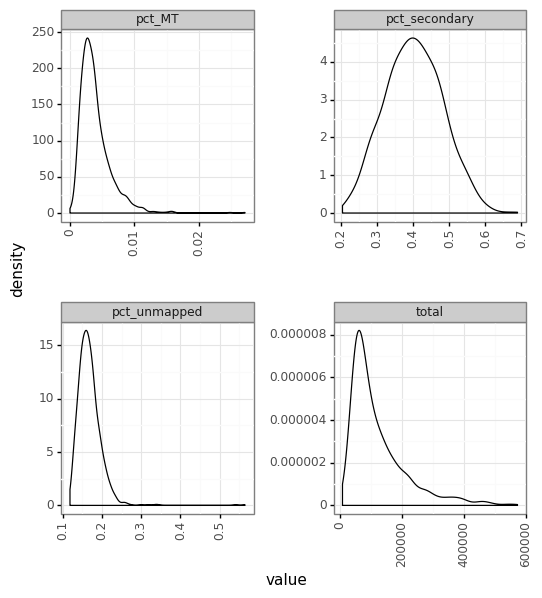

<ggplot: (-9223363245833751068)>


In [164]:
print(filtered_flagCounts.describe())
print(filtered_flagCounts.corr())

plotnine.options.figure_size = (6,6)
print(ggplot(pd.melt(filtered_flagCounts, id_vars='barcode'))
      +theme_bw()
      +theme(aspect_ratio=1,
             axis_text_x=element_text(angle=90),
             panel_spacing=0.8)
      +geom_density(aes('value'))
      +facet_wrap('~variable', scales='free', nrow=2))